In [64]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *
import os
import joblib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

这里解释一下alpha的值。alpha几乎都是使用rank()函数来构造的，因此不是原始数据，而是相当于是一种标准化后的值，对原始的分布是肯定有更改的。如果要可视化原始数据的图，使用data_merged文件夹中的数据。

In [65]:
def mse1(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

## 一、读取因子数据

In [66]:
start_date = '2011-04-30'
end_date = '2018-04-30'

In [67]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])

# df_all = df_all[(df_all['date'] >= start_date) & (df_all['date'] <= end_date)]

df_all.drop(['Unnamed: 0', 'Rmrf', 'Smb', 'Hml'], axis=1, inplace=True)
df_all_pivot = df_all.pivot(index='date', columns='asset')

In [68]:
df_all_pivot.columns

MultiIndex([('open', '000001'),
            ('open', '000002'),
            ('open', '000009'),
            ('open', '000012'),
            ('open', '000021'),
            ('open', '000027'),
            ('open', '000031'),
            ('open', '000039'),
            ('open', '000046'),
            ('open', '000059'),
            ...
            (  'ep', '601898'),
            (  'ep', '601899'),
            (  'ep', '601918'),
            (  'ep', '601919'),
            (  'ep', '601939'),
            (  'ep', '601958'),
            (  'ep', '601988'),
            (  'ep', '601989'),
            (  'ep', '601991'),
            (  'ep', '601998')],
           names=[None, 'asset'], length=7776)

In [69]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
all_time_index = returns.index
all_time_index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [70]:
assets = returns.columns

In [71]:
df_all_pivot['rf'] /= 100

In [72]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20110430'

from MyBacktrader import get_alpha_list

alpha_names = get_alpha_list(f'alphas/{alphaset}/{subset}')
# alpha_names = ['alpha_financial_health']

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)

    # 给 alpha 添加双重索引
    alpha.columns = pd.MultiIndex.from_product([[f'{alpha_name}'], alpha.columns], names=['', 'asset'])

    # 合并 alpha 到 df_all_pivot
    df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)


In [73]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'alpha_CH3', 'ep','alpha_Hml', 'alpha_Hml_NOT','alpha_Smb', 'alpha_Smb_NOT','alpha_CH3_Size',
       'alpha_CH3_Size_NOT', 'alpha_CH3_turnover', 'alpha_CH3_turnover_NOT','alpha_CH3_Value', 'alpha_CH3_Value_NOT'], axis=1, level=0)

X = X[(X.index >= start_date) & (X.index <= end_date)]

X.columns.get_level_values(0).unique()

Index(['alpha001', 'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD',
       'alpha_EMQ', 'alpha_EP', 'alpha_EPQ', 'alpha_financial_health',
       'alpha_High_Low', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf_original', 'alpha_ROA_momentum', 'alpha_ROE',
       'alpha_ROE_ROA', 'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ',
       'alpha_SGQ_volatility', 'alpha_size', 'alpha_trade_density',
       'alpha_turnover', 'alpha_turnover_10', 'alpha_turnover_month',
       'alpha_Volume_Close', 'alpha_vol_skew'],
      dtype='object')

In [74]:
X.index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19',
               '2018-04-20', '2018-04-23', '2018-04-24', '2018-04-25',
               '2018-04-26', '2018-04-27'],
              dtype='datetime64[ns]', name='date', length=1702, freq=None)

## 二、普通的线性回归

In [75]:
def linear_regression(y, X):
    model = LinearRegression()
    model.fit(X, y)
    return model

In [76]:
# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
# linear_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

linear_models = {}

total_mse_linear = 0
linear_preds = pd.DataFrame(index=dates, columns=assets)

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列

    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    linear_preds[asset] = pred

    # 计算 MSE
    mse_val = mse1(y, pred)
    total_mse_linear += mse_val

    # 记录回归结果
    result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    linear_models[asset] = model

100%|██████████| 288/288 [00:03<00:00, 80.21it/s]


## 三、逐步回归

注意，这里我尝试了一下使用稳健标准误（见下面的两行注释），预测结果反而变差了，如果更注重预测结果，把括号里的cov_type = 'HC3'去掉

In [77]:
def stepwise_regression(y, X, direction='both', threshold_in=0.05, threshold_out=0.10):
    """
    逐步回归方法，进行特征选择，返回最优模型以及选择的特征
    :param y: 目标变量（依赖变量）
    :param X: 特征变量（自变量）
    :param direction: 选择方法：'forward'、'backward' 或 'both'
    :param threshold_in: 进入模型的显著性水平
    :param threshold_out: 离开模型的显著性水平
    :return: 最优模型以及选择的特征
    """
    initial_vars = X.columns.tolist()
    best_aic = float('inf')
    best_model = None
    remaining_vars = initial_vars.copy()
    selected_vars = []

    while True:
        changed = False
        
        if direction in ['both', 'forward']:  # 前向选择
            # 遍历所有未进入模型的变量
            for var in remaining_vars:
                model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit(cov_type='HC3')#使用稳健标准误
                aic = model.aic
                # 仅当 AIC 更低时才加入该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.append(best_var)
                    remaining_vars.remove(best_var)
                    break  # 只选择一个变量后继续向前

        if direction in ['both', 'backward']:  # 后向剔除
            # 遍历所有已进入模型的变量
            for var in selected_vars:
                temp_selected_vars = selected_vars.copy()
                temp_selected_vars.remove(var)
                model = sm.OLS(y, sm.add_constant(X[temp_selected_vars])).fit(cov_type='HC3') #使用稳健标准误
                aic = model.aic
                # 仅当 AIC 更低时才剔除该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.remove(best_var)
                    break  # 只剔除一个变量后继续向后

        if not changed:
            break  # 没有变化，退出循环

    return best_model, selected_vars  # 返回最优模型及选择的特征

In [78]:
import joblib

# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
# regression_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

regression_models = {}
regression_preds = pd.DataFrame(index=dates, columns=assets)

total_mse_regression = 0

# 这里是因为我已经保存过模型了，所以直接读取模型。如果要跑的话把下面一整段的注释取掉一次即可

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 对特征进行逐步回归
    stepwise_model, selected_vars = stepwise_regression(y, x)

    # print(selected_vars)
    # print(stepwise_model.summary())
    
    # 获取逐步回归后的预测值
    pred = stepwise_model.predict(sm.add_constant(x[selected_vars]))  # 用最终选择的特征进行预测
    regression_preds[asset] = pred

    # 计算 MSE
    mse_val = mse1(y, pred)
    total_mse_regression += mse_val

    # 记录回归结果
    result = [asset] + list(stepwise_model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    regression_models[asset] = stepwise_model
    
    # 可以选择取消注释下面的代码来保存模型
    
    # # 如果路径不存在，创建路径
    # if not os.path.exists('models/regression_models'):
    #     os.makedirs('models/regression_models')
    
    # joblib.dump(stepwise_model, f'models/regression_models/{asset}.pkl')

print("MSE:")
print(total_mse_regression)

100%|██████████| 288/288 [03:36<00:00,  1.33it/s]

MSE:
0.11200268421351252


下面是画图函数

In [79]:
plt.rcParams['axes.unicode_minus'] = False
def plot_y_and_pred(y, pred, asset_id, ifshow=True):
    plt.figure(figsize=(10, 6))
    plt.scatter(y.index, y, label='True', s = 5)
    plt.scatter(pred.index, pred, label='Predicted', s = 5)
    plt.title(f'True and Predicted Returns of {asset_id}')
    plt.legend()
    
    if ifshow:
        plt.show()
        
    else:
        plt.savefig(f'output_charts/predicts/{asset_id}.png')
        plt.close()

In [80]:
# 提取该资产对应的 Y 和 pred
y1 = returns - df_all_pivot['rf'].values
index_all = y1.index
X1 = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm','alpha_CH3', 'ep'], axis=1, level=0)

def plot_test_pred(y, X, asset_id, ifshow=True, isXgb=False):
       y1 = y[asset_id].dropna()
       y1 = pd.Series(y1, index=index_all)

       model = regression_models[asset_id]
       selected_vars = model.params.index.tolist()
       
       isIntercept = False
       if('Intercept' in selected_vars):
              isIntercept = True
       isconst = False
       if('const' in selected_vars):
              isconst = True
       
       selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
       
       # print(model.params)
       
       # print(model.params.shape)
       X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
       
       if 'const' not in X2.columns and isconst:
              X2 = sm.add_constant(X2)
       if isIntercept:
              X2['Intercept'] = 1
              
       # print(X2.columns)
       
       pred = model.predict(X2)
       
       pred = pd.Series(pred, index=index_all)
       
       print(X.shape, y1.shape, pred.shape)
       
       test_mse = mse1(y1, pred)
       print(f"Test MSE: {test_mse}")       
       
       plot_y_and_pred(y1, pred, asset_id, ifshow)


画图函数的使用

(2918, 12672) (2918,) (2918,)
Test MSE: 0.00014484407297390758


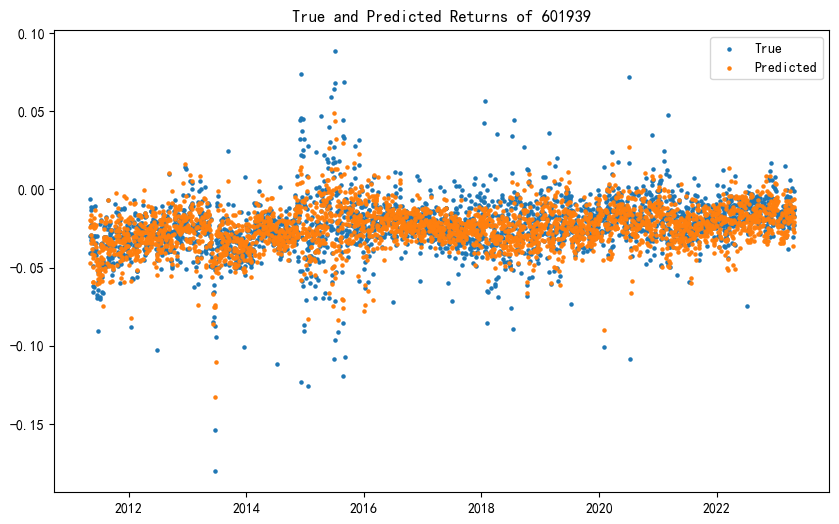

In [81]:
asset_id = '601939'

%matplotlib inline

plot_test_pred(y1, X1, asset_id, isXgb=False)

## 四、模型检验

In [82]:
# 选取一个model

asset_id = '601939'

results = regression_models[asset_id]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     94.04
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          3.25e-166
Time:                        19:09:11   Log-Likelihood:                 5005.1
No. Observations:                1693   AIC:                            -9986.
Df Residuals:                    1681   BIC:                            -9921.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0099 

残差正态性检验：可以通过残差的 Q-Q 图或 Shapiro-Wilk 检验来评估。

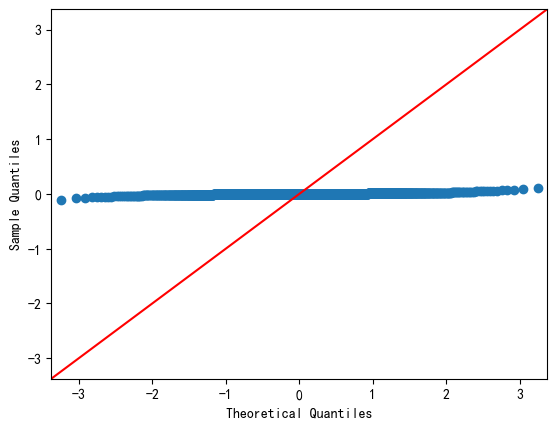

Shapiro-Wilk p-value: 3.2343029682055365e-36


In [99]:
import scipy.stats as stats

# Q-Q图
sm.qqplot(results.resid, line ='45')
plt.show()

# Shapiro-Wilk检验
stat, p_value = stats.shapiro(results.resid)
print(f'Shapiro-Wilk p-value: {p_value}')

异方差性检验（Breusch-Pagan检验）：用于检验模型是否存在异方差性。

In [84]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan 异方差性检验
bp_test = het_breuschpagan(results.resid, results.model.exog)
print(bp_test)  # 输出包括LM统计量和p值


(np.float64(180.36407728222954), np.float64(8.621684706176369e-33), np.float64(18.221774282645455), np.float64(9.375193540340326e-35))


自相关检验（Durbin-Watson检验）：用于检验残差是否存在自相关（尤其在时间序列数据中）。

In [85]:
# Durbin-Watson 检验
dw_stat = sm.stats.durbin_watson(results.resid)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 1.964288982547664


多重共线性检验：方差膨胀因子（VIF），VIF 值较高（如 > 10）表示存在严重共线性问题。

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 要提取单个股票的x和y时使用这段代码
y = Y[asset_id].dropna()
x = X.xs(asset_id, axis=1, level=1).reindex(y.index)

# 计算VIF
X_no_const = x.iloc[:, 1:]  # 去掉常数项
vif = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]
vif = pd.Series(vif, index=X_no_const.columns, name='VIF')
print(vif)

alpha_ALAQ                      NaN
alpha_bm                   0.000000
alpha_CTA                       NaN
alpha_CVD                  2.385386
alpha_EMQ                       NaN
alpha_EP                   0.000000
alpha_EPQ                  0.000000
alpha_financial_health          NaN
alpha_High_Low             3.433943
alpha_liquidity                 NaN
alpha_market_alpha         8.643649
alpha_momentum             2.257554
alpha_momentum_60          2.323136
alpha_multi                5.461515
alpha_PMQ                  3.042274
alpha_PMQ_momentum         1.605033
alpha_Price_VWAP           1.046971
alpha_reversal             7.906147
alpha_Rmrf_original        1.134677
alpha_ROA_momentum         3.330267
alpha_ROE                  2.212253
alpha_ROE_ROA              1.935400
alpha_rsi                  2.104832
alpha_sentiment            2.356235
alpha_SGQ                  2.762237
alpha_SGQ_volatility       2.046594
alpha_size                 9.334635
alpha_trade_density        7

e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


## 五、模型优化

可以只对一个股票进行模型优化，比如使用WLS,LASSO,Ridge

In [87]:
# 从模型中提取出逐步回归选择的变量作为接下来优化的基础，也可以不进行这一步，直接使用所有变量
# selected_vars_id = results.params.index.tolist()


y = Y[asset_id].dropna()
# x = X.xs(asset_id, axis=1, level=1).reindex(y.index)[selected_vars_id]
x = X.xs(asset_id, axis=1, level=1).reindex(y.index)

# print(selected_vars_id)

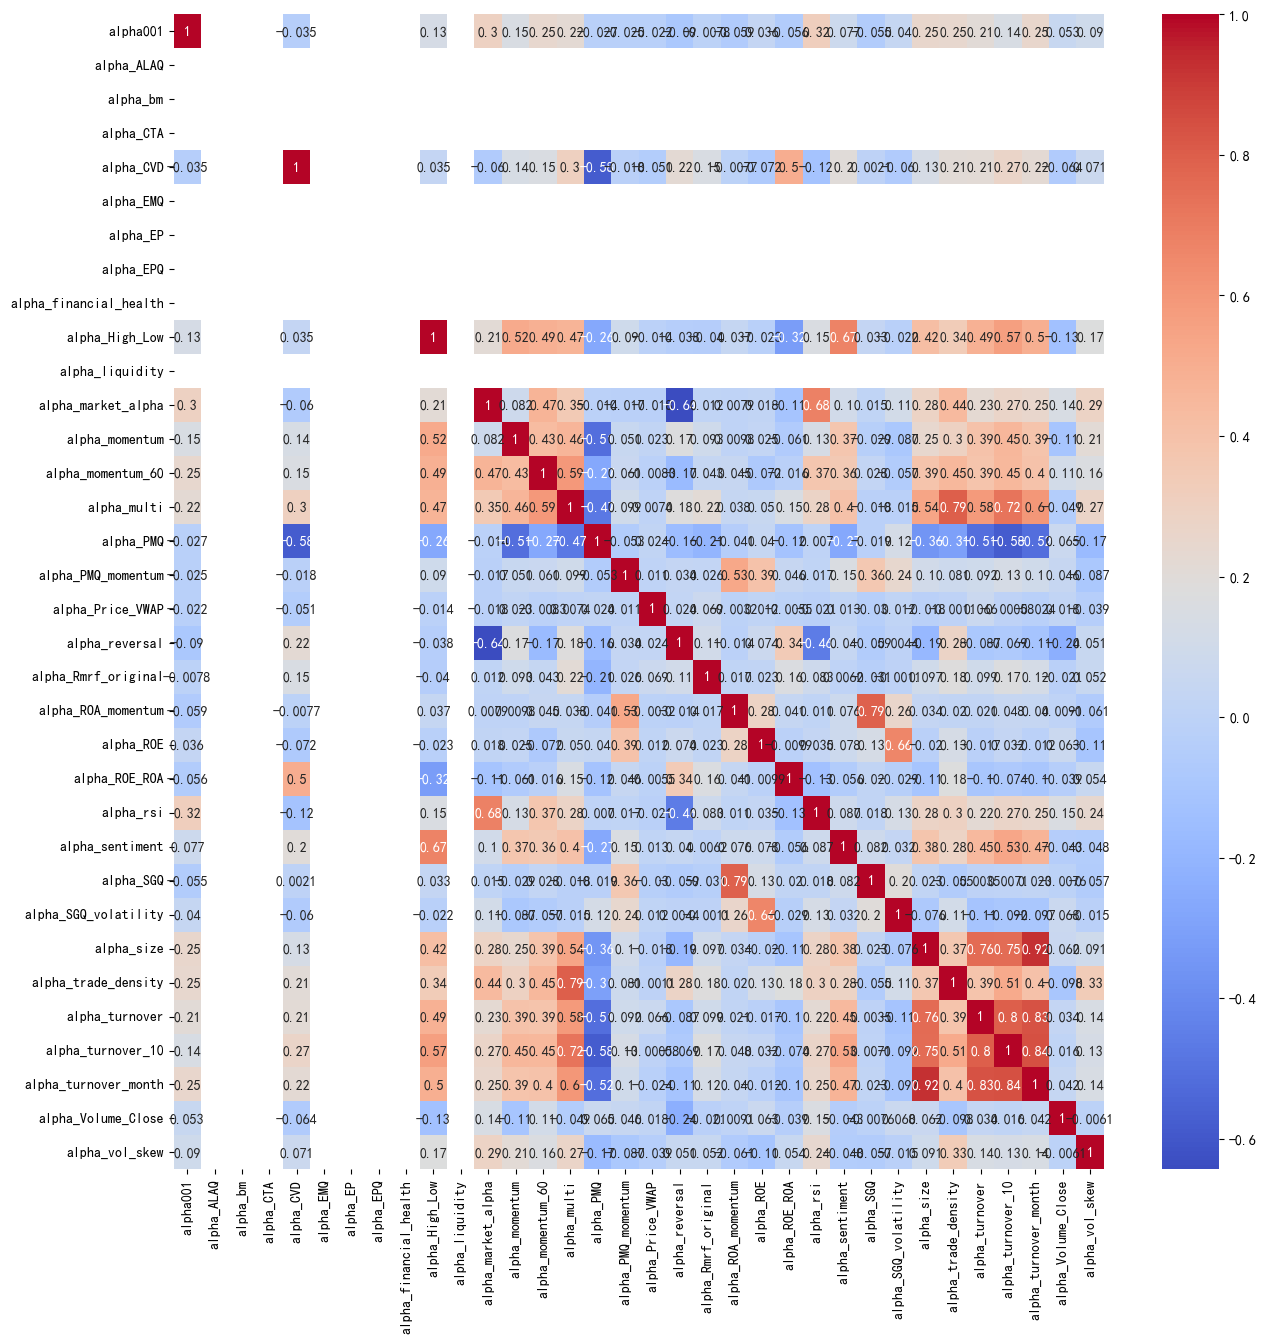

In [88]:
import seaborn as sns

# 计算相关矩阵
corr_matrix = x.corr()

# 绘制热图查看相关性
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

PCA

Explained variance ratio by each component: [2.52534346e-01 1.05266095e-01 9.94538940e-02 7.18094879e-02
 5.72143151e-02 5.04999315e-02 4.06167361e-02 3.83254105e-02
 3.59609961e-02 3.40683754e-02 3.20722445e-02 3.12404637e-02
 2.49168366e-02 2.26753412e-02 1.77828292e-02 1.65011870e-02
 1.35687582e-02 1.02146244e-02 8.69455172e-03 8.38950663e-03
 7.16506153e-03 6.72453379e-03 6.35346816e-03 4.31940177e-03
 2.11076503e-03 1.52083947e-03 3.94968314e-17 2.95745419e-17
 1.72875061e-17 3.16710015e-18 2.67731858e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Principal components (eigenvectors):
[[ 1.20656147e-01  4.44089210e-16 -0.00000000e+00 ...  3.35319522e-01
   7.53316272e-04  1.08939438e-01]
 [-1.63086972e-01 -1.11022302e-16 -1.11022302e-16 ...  4.22861014e-03
  -1.98150169e-01 -5.53796973e-03]
 [-8.65731400e-02 -1.38777878e-16 -5.55111512e-17 ... -1.95848886e-02
  -1.84833581e-02 -1.13613239e-01]
 ...
 [-0.00000000e+00 -3.03534287e-02  4.67247276e-01 ... -2.92319730e-15
   1.8656

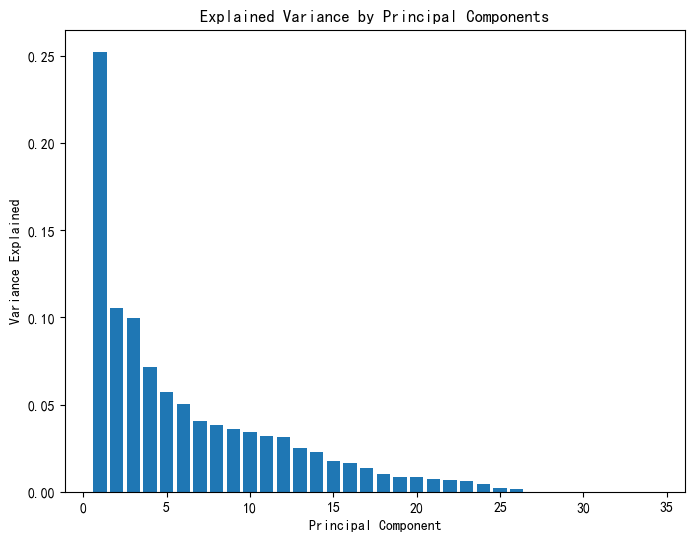

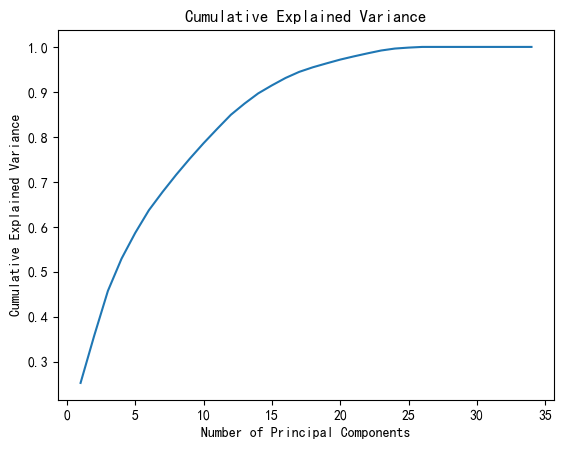

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设 X 是你的特征数据
# Step 1: 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)  # 对数据进行标准化

# Step 2: 执行 PCA
pca = PCA()  # 可以选择保留多少个主成分，默认会保留全部主成分
pca.fit(X_scaled)

# Step 3: 查看每个主成分的方差解释比例
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: 查看每个主成分的方差解释比例
print("Explained variance ratio by each component:", explained_variance_ratio)

# Step 5: 查看每个主成分的特征向量（系数）
print("Principal components (eigenvectors):")
print(pca.components_)

# Step 6: 转换数据到主成分空间
X_pca = pca.transform(X_scaled)

# Step 7: 绘制主成分的方差解释比例图
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.show()

# Step 8: 累积解释的方差比例（用于决定保留多少主成分）
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

# Step 9: 如果你只想保留前 k 个主成分，可以使用:
pca = PCA(n_components=5)  # 例如保留前 5 个主成分
X_pca = pca.fit_transform(X_scaled)

使用WLS

In [90]:
# 权重（可以是方差的倒数等，这里假设是一个简单的权重）
weights = 1 / (y ** 2)  # 这里使用简单的权重作为示例，具体情况视实际需求而定

# 加入常数项
x_wls = sm.add_constant(x)

# 进行 WLS 回归
wls_model = sm.WLS(y, x_wls, weights=weights).fit()

# 打印结果
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.509
Model:                            WLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     66.53
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          1.86e-235
Time:                        19:09:13   Log-Likelihood:                 4547.5
No. Observations:                1693   AIC:                            -9041.
Df Residuals:                    1666   BIC:                            -8894.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
alpha001                   0

In [91]:
# PCA后

# 权重（可以是方差的倒数等，这里假设是一个简单的权重）
weights = 1 / (y ** 2)  # 这里使用简单的权重作为示例，具体情况视实际需求而定

# 加入常数项
x_wls_pca = sm.add_constant(X_pca)

# 进行 WLS 回归
wls_model_pca = sm.WLS(y, x_wls_pca, weights=weights).fit()

# 打印结果
print(wls_model_pca.summary())

                            WLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.073
Model:                            WLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     26.74
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           4.29e-26
Time:                        19:09:13   Log-Likelihood:                 4009.3
No. Observations:                1693   AIC:                            -8007.
Df Residuals:                    1687   BIC:                            -7974.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -12.396      0.0

使用LASSO: 评价是系数逆天

In [92]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 分割数据集，通常 LASSO 需要进行交叉验证来选择最佳的正则化参数
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 Lasso 模型，选择合适的正则化参数 alpha
lasso_model = Lasso(alpha=0.1)  # alpha 控制正则化强度

# 训练 Lasso 模型
lasso_model.fit(x_train, y_train)

# 获取模型系数
print("Lasso coefficients:", lasso_model.coef_)

# 预测并计算 MSE
y_pred = lasso_model.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred)
print(f'MSE for Lasso: {mse_lasso:.8f}')

Lasso coefficients: [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.
 -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
MSE for Lasso: 0.00026702


In [93]:
# 使用PCA后

# 分割数据集，通常 LASSO 需要进行交叉验证来选择最佳的正则化参数
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 初始化 Lasso 模型，选择合适的正则化参数 alpha
lasso_model = Lasso(alpha=0.1)  # alpha 控制正则化强度

# 训练 Lasso 模型
lasso_model.fit(x_train, y_train)

# 获取模型系数
print("Lasso coefficients:", lasso_model.coef_)

# 预测并计算 MSE
y_pred = lasso_model.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred)
print(f'MSE for Lasso: {mse_lasso:.8f}')

Lasso coefficients: [ 0.  0.  0.  0. -0.]
MSE for Lasso: 0.00026702


使用Ridge

In [94]:
from sklearn.linear_model import Ridge

# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 Ridge 模型，选择合适的正则化参数 alpha
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度

# 训练 Ridge 模型
ridge_model.fit(x_train, y_train)

# 获取模型系数
print("Ridge coefficients:", ridge_model.coef_)

# 预测并计算 MSE
y_pred = ridge_model.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f'MSE for Ridge: {mse_ridge}')

Ridge coefficients: [ 7.14390071e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.71018344e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.79785813e-02  0.00000000e+00 -7.34704597e-03
  9.85292171e-04 -1.29473554e-03  9.22195364e-03 -1.57712864e-02
 -3.78433660e-04 -1.64933632e-03 -8.24462456e-03  2.14067713e-01
  7.74802876e-03  2.12103707e-03  1.48433157e-02  7.46943119e-03
 -1.41202867e-03 -8.34283633e-03 -2.84689118e-03 -1.82496293e-02
  5.05367166e-03  3.49712127e-03 -1.40420738e-02  2.69588046e-02
  1.83193341e-04  1.53161706e-03]
MSE for Ridge: 0.00016418173027649407


In [95]:
# PCA后

# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 初始化 Ridge 模型，选择合适的正则化参数 alpha
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度

# 训练 Ridge 模型
ridge_model.fit(x_train, y_train)

# 获取模型系数
print("Ridge coefficients:", ridge_model.coef_)

# 预测并计算 MSE
y_pred = ridge_model.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f'MSE for Ridge: {mse_ridge}')

Ridge coefficients: [ 1.54894337e-03  5.10496501e-04  1.79958449e-05  3.60801112e-03
 -2.99101687e-03]
MSE for Ridge: 0.00020677004074999705
